In [7]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [8]:
# Set random seeds for reproducibility
torch.set_num_threads(4) 

data = pd.read_csv('./MDB.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()


def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  


data.dropna(inplace=True)
data.head(500)

         Date   Open   High     Low  Close    Volume
0  2017-10-19  33.00  34.00  29.100  32.07  11508466
1  2017-10-20  33.37  33.37  30.100  30.68   2358653
2  2017-10-23  30.51  31.33  30.190  30.50    749397
3  2017-10-24  30.46  30.92  30.439  30.57    420725
4  2017-10-25  30.50  31.10  29.880  31.00   1219442


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2017-12-29,30.35,30.3900,29.5200,29.68,324587,29.254,29.022,28.1060,29.2480,29.414513,29.026543,28.775329,29.299191,64.871017
50,2018-01-02,29.93,30.0800,28.8550,29.25,231621,29.414,29.005,28.1785,29.1916,29.359676,29.067172,28.820536,29.297262,59.552358
51,2018-01-03,29.31,29.4200,28.9400,29.15,256707,29.484,29.090,28.2680,29.1610,29.289784,29.082231,28.851913,29.291487,50.716332
52,2018-01-04,29.29,29.4900,28.9000,29.05,198884,29.474,29.190,28.4130,29.1320,29.209856,29.076371,28.870779,29.282017,59.529148
53,2018-01-05,29.09,29.1350,28.5900,29.05,205632,29.236,29.145,28.5220,29.1016,29.156571,29.071576,28.887848,29.272918,55.651106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2019-12-18,129.29,132.3900,128.5600,129.18,1059895,128.794,129.470,137.4205,131.6157,129.554616,131.005356,132.953574,133.502397,27.692308
545,2019-12-19,130.60,132.9000,128.5700,130.96,861351,130.040,129.429,136.5810,131.5655,130.023077,130.997109,132.763710,133.402695,31.071276
546,2019-12-20,131.25,132.6899,129.6600,130.68,836492,130.494,129.380,135.7915,131.5297,130.242052,130.939453,132.565261,133.295923,40.591023
547,2019-12-23,130.75,133.2900,130.1100,132.36,641720,130.514,129.515,135.0135,131.4507,130.948034,131.197734,132.545713,133.259220,34.024768


In [9]:
# Select key features
selected_features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
    'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days',
    'RSI_14'
]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[selected_features])

# Create sequences with reduced length
sequence_length = 30  # Reduced from 60
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader with larger batch size
batch_size = 128  # Increased batch size
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class FastStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_projection(x)
        x = self.layer_norm1(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.layer_norm2(x)
        
        # Final prediction
        return self.fc(x)
    
# Initialize the model


In [10]:
# Initialize the model (ensure the architecture matches the saved model)
model = FastStockPredictor(input_dim=len(selected_features))

# Load the saved model weights
model.load_state_dict(torch.load('stock_predictor_model.pth'))

# Set the model to evaluation mode
model.eval()

C:\Users\timoz\AppData\Local\Temp\ipykernel_22224\1381972418.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('stock_predictor_model.pth'

FastStockPredictor(
  (input_projection): Linear(in_features=14, out_features=128, bias=True)
  (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (layer_norm2): LayerNorm((128,), eps=1e-05, elementwis

In [11]:
# Make predictions
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_X, _ in val_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]

# Get actual values
actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]


Final Model Performance Metrics:
MSE: 749.074
RMSE: 27.369
MAE: 21.596
R2 Score: 0.823


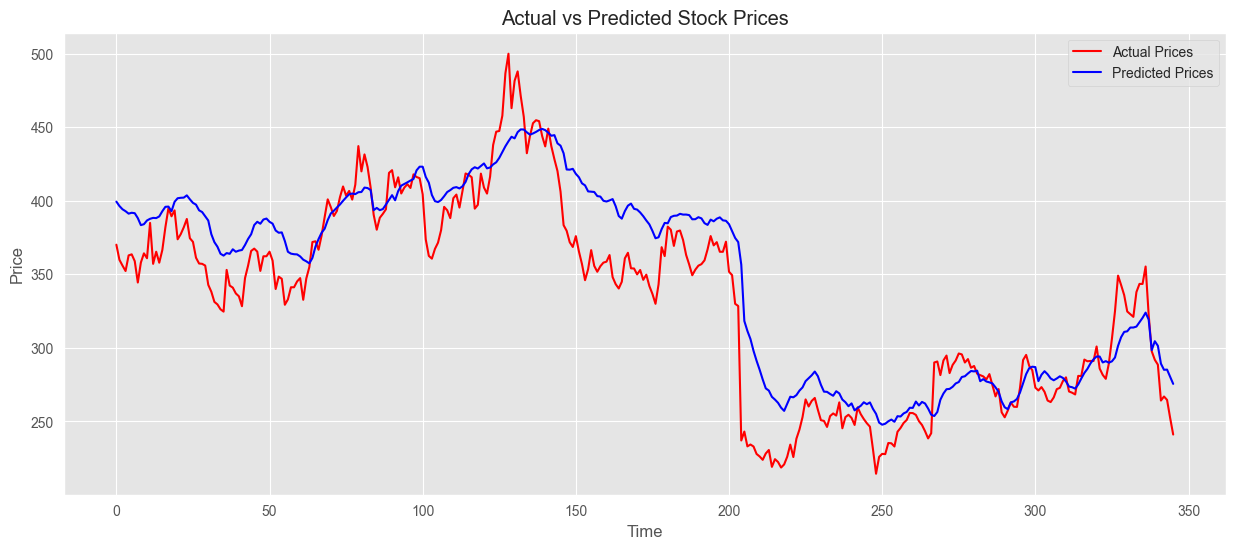

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nFinal Model Performance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# # Plot loss curves
# plt.figure(figsize=(10, 6))
# plt.plot(training_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.title('Model Loss Over Time')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()